In [15]:

# Required Libraries

# Train with no over sampling

from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


def train_and_evaluate(fake_data_path, real_data_path, output_dir):

  # Step 1: Load and Prepare Data
  # put location of dataset here
  data1 = pd.read_csv(fake_data_path)
  data2 = pd.read_csv(real_data_path)

  data = pd.concat([data1, data2], ignore_index=True)
  best_auc = 0
  best_model = None
  best_model_name = ""
  # Encode Labels: FAKE -> 0, REAL -> 1
  label_encoder = LabelEncoder()
  data['type'] = label_encoder.fit_transform(data['type'])
  columns_to_drop = ['file_name', 'interval_start', 'interval_end']  # Drop metadata


  # Separate Features and Labels
  X = data.drop(columns=columns_to_drop + ['type'])
  y = data['type']

  # Normalize Features
  # Split Data: Train/Test (80-20 split)
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42, stratify=y
  )

  # Step 3: Normalize Features (Fit on Training Data Only, Then Transform Test Data)
  scaler = StandardScaler()
  X_train_scaled = X_train  # Fit and transform on training data
  X_test_scaled = X_test  # Only transform on test data

  # Step 4: Define Models
  models = {
      'SVC': SVC(probability=True, random_state=42),  # Enable probability for ROC/PR curves
      'Naive Bayes': GaussianNB(),
      'KNN': KNeighborsClassifier(n_neighbors=5),
      'Random Forest': RandomForestClassifier(random_state=42),
      'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
  }

  # Step 5: Train Models
  for name, model in models.items():
      model.fit(X_train_scaled, y_train)

  # Step 6: Evaluate Model Performance
  def plot_confusion_matrix(cm, title):
      plt.figure(figsize=(5, 4))
      sns.heatmap(
          cm,
          annot=True,
          fmt='d',
          cmap='Blues',
          xticklabels=['FAKE', 'REAL'],
          yticklabels=['FAKE', 'REAL'],
      )
      plt.xlabel('Predicted')
      plt.ylabel('Actual')
      plt.title(title)
      plt.show()

  print("\n=== Model Performance ===")
  for name, model in models.items():
      y_pred = model.predict(X_test_scaled)
      cm = confusion_matrix(y_test, y_pred)

      # Print Metrics
      print(f"\n{name} Metrics:")
      print(classification_report(y_test, y_pred, target_names=['FAKE', 'REAL']))

      # Plot Confusion Matrix
      plot_confusion_matrix(cm, title=f'{name} Confusion Matrix')

  # Step 7: Precision-Recall and ROC Curves
  print("\n=== Precision-Recall and ROC Curves ===")
  for name, model in models.items():
      if hasattr(model, "predict_proba"):
          y_proba = model.predict_proba(X_test_scaled)[:, 1]
      else:
          y_proba = model.decision_function(X_test_scaled)

      # Plot Precision-Recall Curve
      PrecisionRecallDisplay.from_predictions(y_test, y_proba)
      plt.title(f'{name} Precision-Recall Curve')
      plt.show()

      # Plot ROC Curve
      RocCurveDisplay.from_predictions(y_test, y_proba)
      plt.title(f'{name} ROC Curve')
      plt.show()

      # Print AUC-ROC
      auc = roc_auc_score(y_test, y_proba)
      print(f"{name} AUC-ROC: {auc:.4f}")

      if auc > best_auc:
          best_auc = auc
          best_model = model
          best_model_name = name

  # Step 8: Cross-Validation
  print("\n=== Cross-Validation Scores ===")
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  for name, model in models.items():
      scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')  # Only use training data for CV
      print(f"{name} Cross-Validation Accuracy: Mean = {scores.mean():.4f}, Std = {scores.std():.4f}")

  # Step 9: Feature Importance
  print("\n=== Feature Importance ===")
  for name, model in models.items():
      print(f"\n{name} Feature Importance:")
      if hasattr(model, "feature_importances_"):  # For models like Random Forest
          feature_importances = model.feature_importances_
          importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
          importance_df = importance_df.sort_values(by='Importance', ascending=False)
      else:
          # Use permutation importance for models without intrinsic feature importance
          perm_importance = permutation_importance(model, X_test_scaled, y_test, scoring='accuracy', random_state=42)
          importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
          importance_df = importance_df.sort_values(by='Importance', ascending=False)

      # Print Top Features
      print(importance_df.head())

      # Plot Feature Importances
      plt.figure(figsize=(10, 6))
      sns.barplot(x='Importance', y='Feature', data=importance_df)
      plt.title(f'{name} Feature Importances')
      plt.xlabel('Importance')
      plt.ylabel('Feature')
      plt.show()

  # Step 10: Save the Best Model
  if best_model is not None:
      print(f"\nSaving the best model: {best_model_name} with AUC-ROC: {best_auc:.4f}")
      joblib.dump(best_model, f"{best_model_name}_best_model.joblib")
  else:
      print("No model performed well enough to be saved.")



=== Model Performance ===

SVC Metrics:
              precision    recall  f1-score   support

        FAKE       0.88      1.00      0.93      2086
        REAL       0.00      0.00      0.00       298

    accuracy                           0.88      2384
   macro avg       0.44      0.50      0.47      2384
weighted avg       0.77      0.88      0.82      2384



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


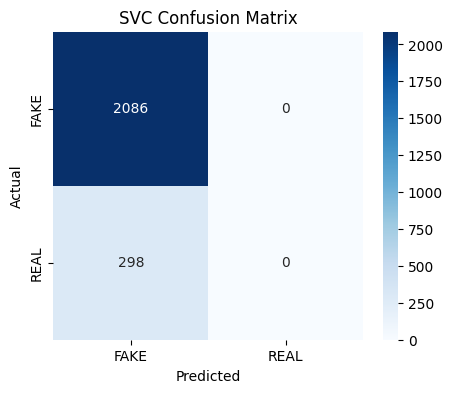


Naive Bayes Metrics:
              precision    recall  f1-score   support

        FAKE       0.90      0.90      0.90      2086
        REAL       0.29      0.28      0.29       298

    accuracy                           0.83      2384
   macro avg       0.59      0.59      0.59      2384
weighted avg       0.82      0.83      0.82      2384



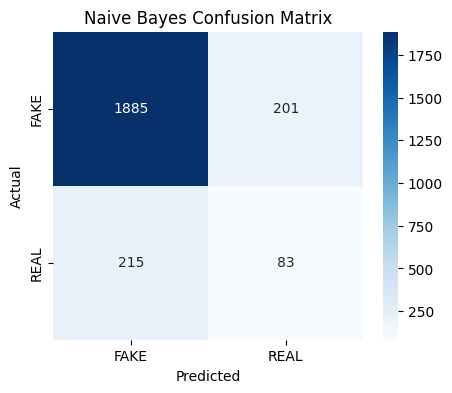


KNN Metrics:
              precision    recall  f1-score   support

        FAKE       0.88      0.98      0.93      2086
        REAL       0.38      0.09      0.15       298

    accuracy                           0.87      2384
   macro avg       0.63      0.54      0.54      2384
weighted avg       0.82      0.87      0.83      2384



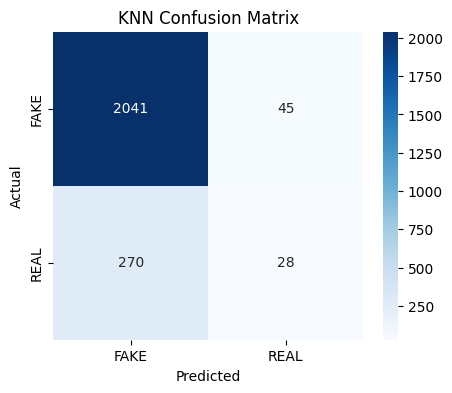


Random Forest Metrics:
              precision    recall  f1-score   support

        FAKE       0.93      1.00      0.96      2086
        REAL       0.99      0.46      0.63       298

    accuracy                           0.93      2384
   macro avg       0.96      0.73      0.79      2384
weighted avg       0.94      0.93      0.92      2384



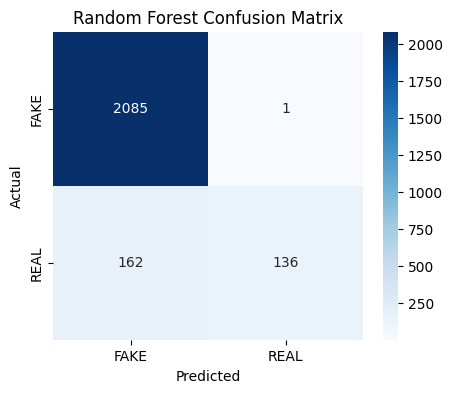


XGBoost Metrics:
              precision    recall  f1-score   support

        FAKE       0.95      0.99      0.97      2086
        REAL       0.93      0.67      0.78       298

    accuracy                           0.95      2384
   macro avg       0.94      0.83      0.88      2384
weighted avg       0.95      0.95      0.95      2384



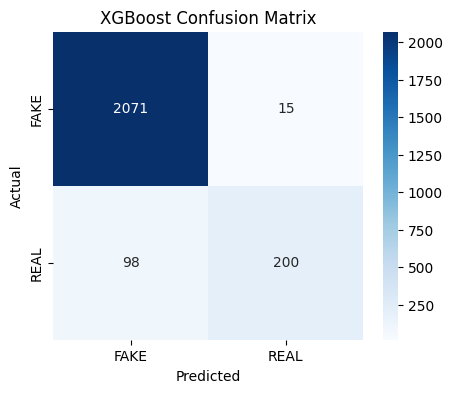


=== Precision-Recall and ROC Curves ===


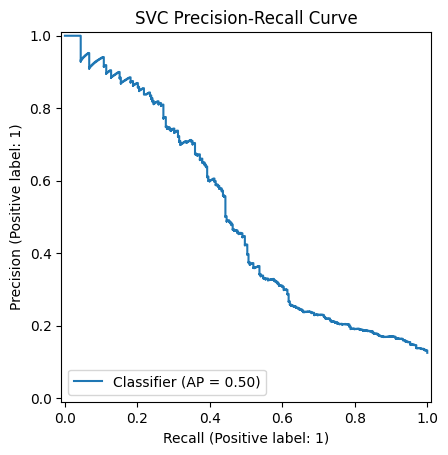

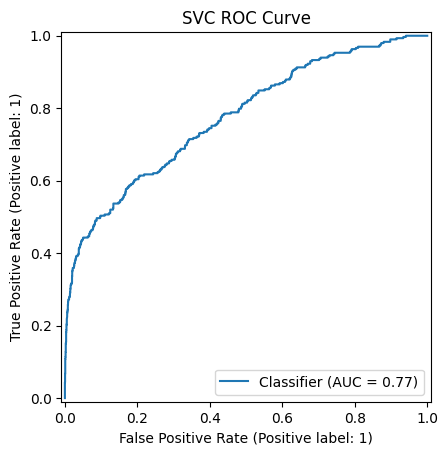

SVC AUC-ROC: 0.7743


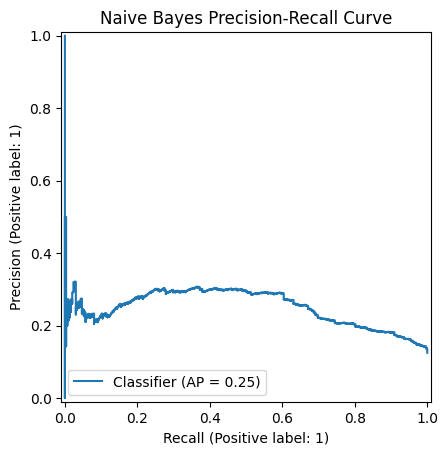

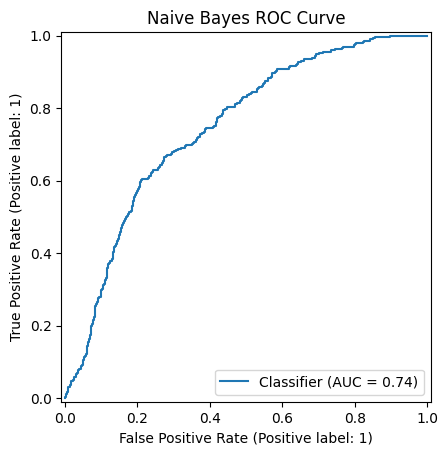

Naive Bayes AUC-ROC: 0.7448


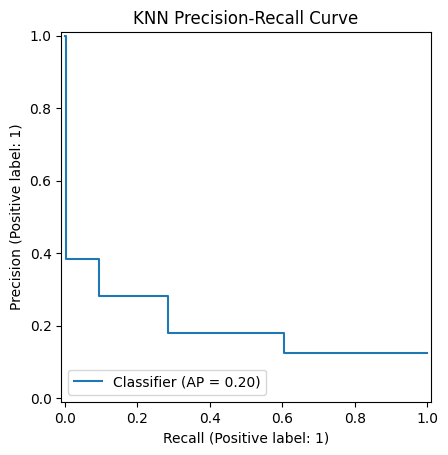

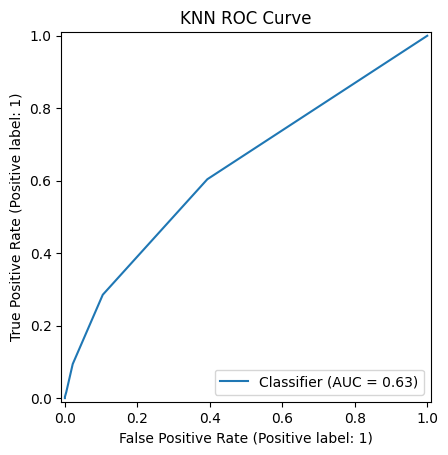

KNN AUC-ROC: 0.6318


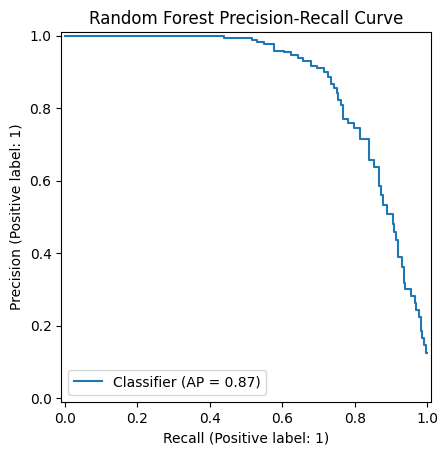

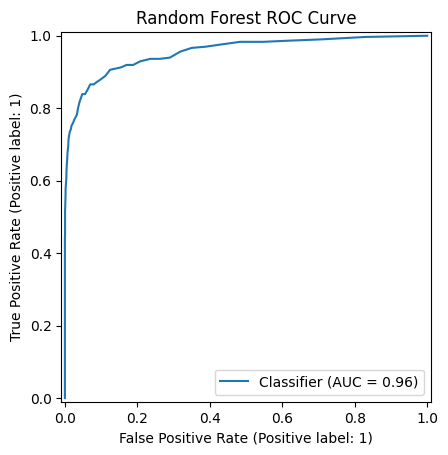

Random Forest AUC-ROC: 0.9552


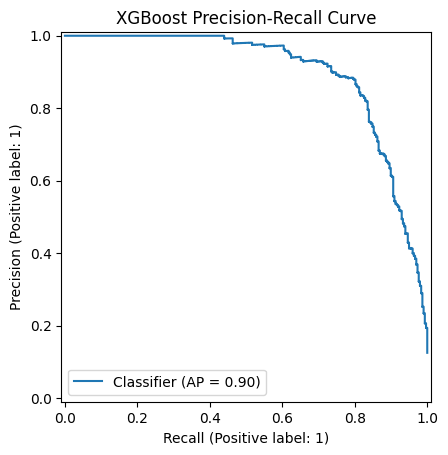

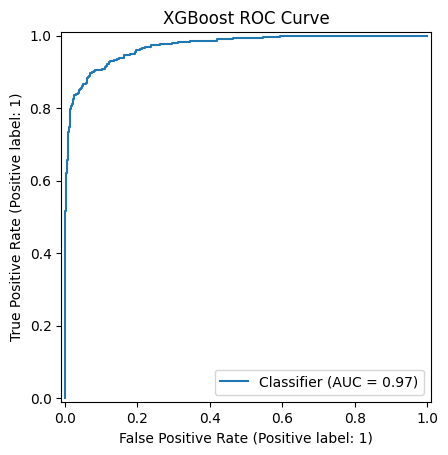

XGBoost AUC-ROC: 0.9716

=== Cross-Validation Scores ===
SVC Cross-Validation Accuracy: Mean = 0.8750, Std = 0.0002
Naive Bayes Cross-Validation Accuracy: Mean = 0.8316, Std = 0.0046
KNN Cross-Validation Accuracy: Mean = 0.8661, Std = 0.0042
Random Forest Cross-Validation Accuracy: Mean = 0.9284, Std = 0.0031
XGBoost Cross-Validation Accuracy: Mean = 0.9534, Std = 0.0016

=== Feature Importance ===

SVC Feature Importance:
               Feature  Importance
0               mfcc_0         0.0
1               mfcc_1         0.0
24  zero_crossing_rate         0.0
23    spectral_rolloff         0.0
22  spectral_bandwidth         0.0


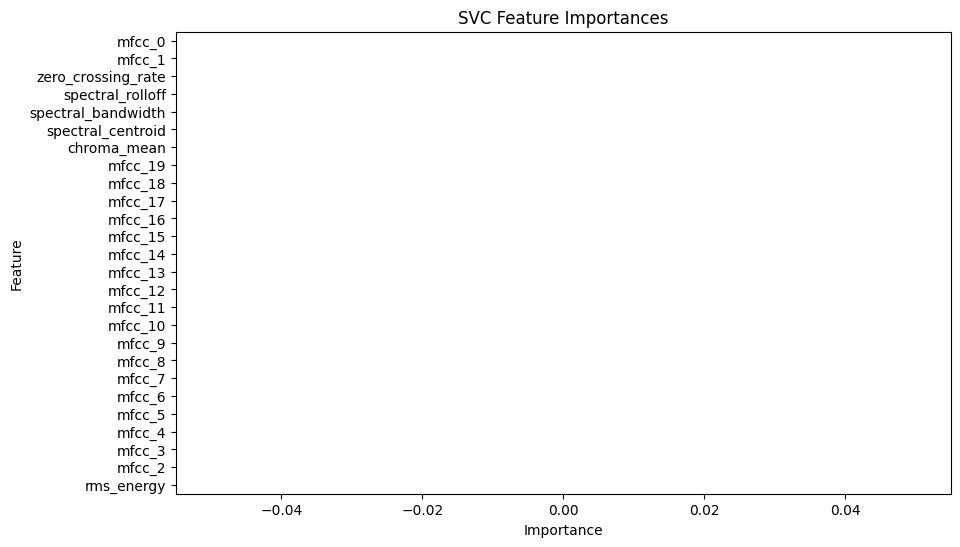


Naive Bayes Feature Importance:
               Feature  Importance
2               mfcc_2    0.007634
11             mfcc_11    0.006040
20         chroma_mean    0.004362
22  spectral_bandwidth    0.003020
17             mfcc_17    0.002097


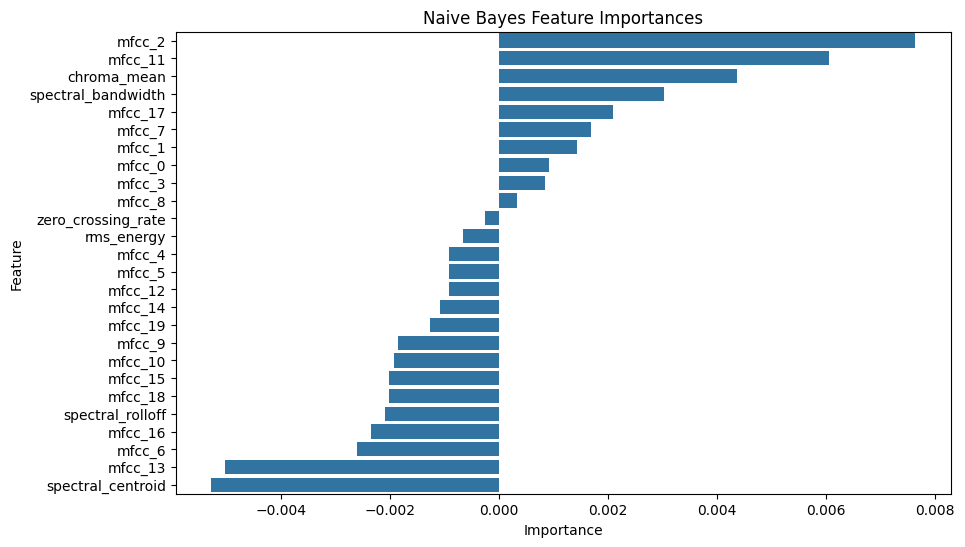


KNN Feature Importance:
               Feature  Importance
21   spectral_centroid    0.026091
22  spectral_bandwidth    0.024329
0               mfcc_0    0.007466
1               mfcc_1    0.002349
2               mfcc_2    0.001342


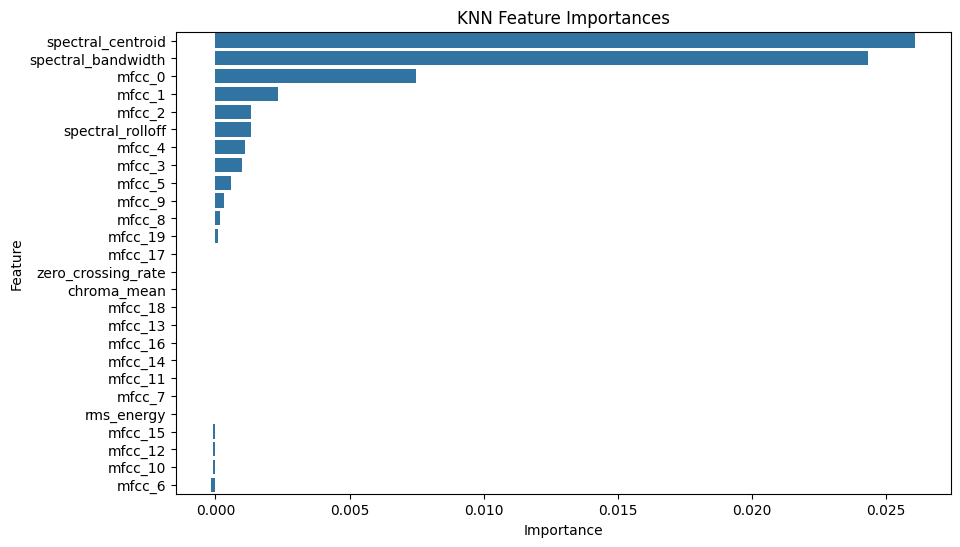


Random Forest Feature Importance:
       Feature  Importance
19     mfcc_19    0.076903
25  rms_energy    0.060743
0       mfcc_0    0.056807
11     mfcc_11    0.054957
17     mfcc_17    0.052986


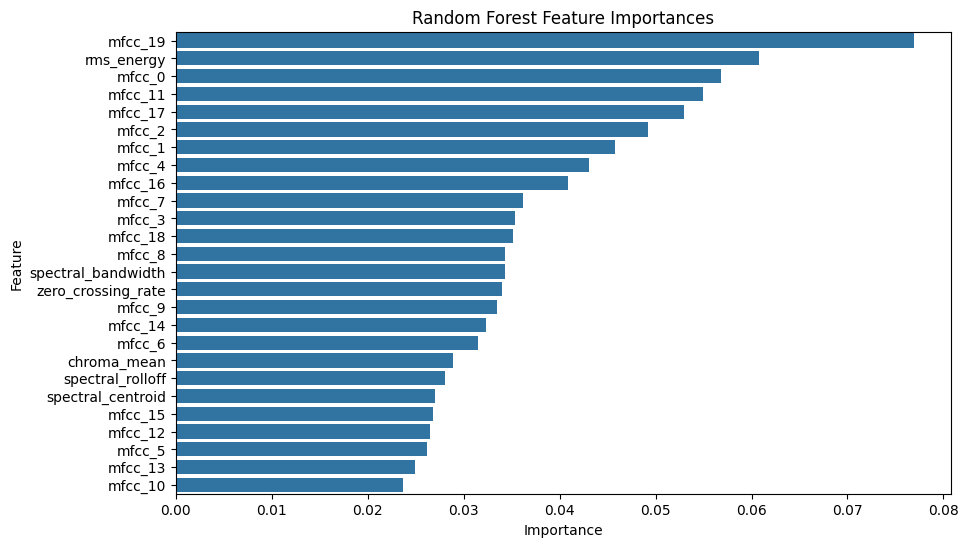


XGBoost Feature Importance:
       Feature  Importance
19     mfcc_19    0.075742
25  rms_energy    0.072906
11     mfcc_11    0.065631
17     mfcc_17    0.063866
2       mfcc_2    0.059743


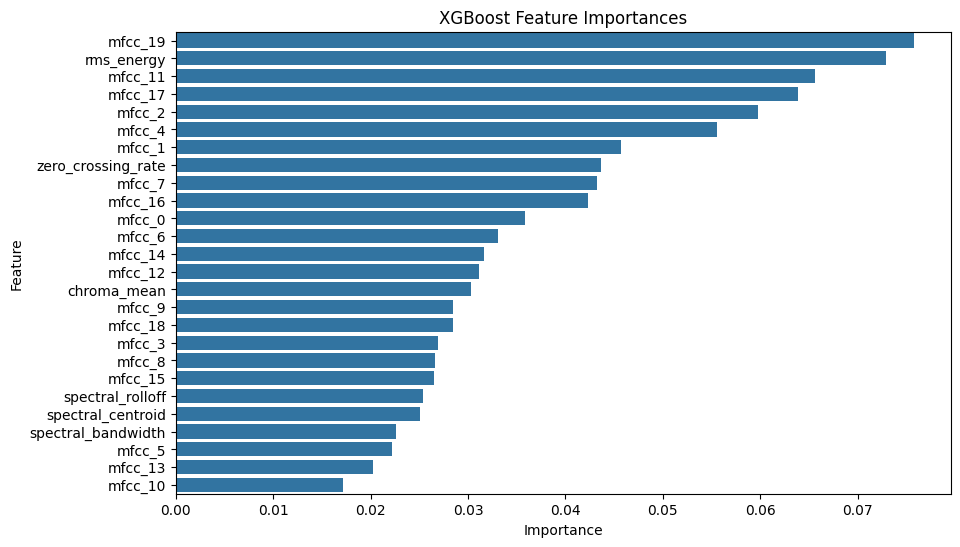


Saving the best model: XGBoost with AUC-ROC: 0.9716


In [16]:
train_and_evaluate("/content/drive/MyDrive/KAGGLE/AUDIO/FAKE_REDUCED/FAKE_REDUCED_audio_features_3Secs.csv",
                   "/content/drive/MyDrive/KAGGLE/AUDIO/REAL_REDUCED/REAL_REDUCED_audio_features_3Secs.csv", " ")


In [17]:
from imblearn.over_sampling import SMOTE
# train with oversampling
def train_and_evaluate_OverSample(fake_data_path, real_data_path, output_dir):
    # Step 1: Load and Prepare Data
    data1 = pd.read_csv(fake_data_path)
    data2 = pd.read_csv(real_data_path)

    data = pd.concat([data1, data2], ignore_index=True)
    best_auc = 0
    best_model = None
    best_model_name = ""

    # Encode Labels: FAKE -> 0, REAL -> 1
    label_encoder = LabelEncoder()
    data['type'] = label_encoder.fit_transform(data['type'])
    columns_to_drop = ['file_name', 'interval_start', 'interval_end']  # Drop metadata

    # Separate Features and Labels
    X = data.drop(columns=columns_to_drop + ['type'])
    y = data['type']

    # Step 2: Split Data (80-20 split)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Step 3: Apply SMOTE to Training Data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Step 4: Define Models
    models = {
        'SVC': SVC(probability=True, random_state=42),
        'Naive Bayes': GaussianNB(),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    }

    # Step 5: Train Models
    for name, model in models.items():
        model.fit(X_train_resampled, y_train_resampled)

    # Step 6: Evaluate Model Performance
    def plot_confusion_matrix(cm, title):
        plt.figure(figsize=(5, 4))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['FAKE', 'REAL'],
            yticklabels=['FAKE', 'REAL'],
        )
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(title)
        plt.show()

    print("\n=== Model Performance ===")
    for name, model in models.items():
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        # Print Metrics
        print(f"\n{name} Metrics:")
        print(classification_report(y_test, y_pred, target_names=['FAKE', 'REAL']))

        # Plot Confusion Matrix
        plot_confusion_matrix(cm, title=f'{name} Confusion Matrix')

    # Step 7: Precision-Recall and ROC Curves
    print("\n=== Precision-Recall and ROC Curves ===")
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = model.decision_function(X_test)

        # Plot Precision-Recall Curve
        PrecisionRecallDisplay.from_predictions(y_test, y_proba)
        plt.title(f'{name} Precision-Recall Curve')
        plt.show()

        # Plot ROC Curve
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f'{name} ROC Curve')
        plt.show()

        # Print AUC-ROC
        auc = roc_auc_score(y_test, y_proba)
        print(f"{name} AUC-ROC: {auc:.4f}")

        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_model_name = name

    # Step 8: Cross-Validation
    print("\n=== Cross-Validation Scores ===")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for name, model in models.items():
        scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=cv, scoring='accuracy')
        print(f"{name} Cross-Validation Accuracy: Mean = {scores.mean():.4f}, Std = {scores.std():.4f}")
    print("\n=== Feature Importance ===")
    for name, model in models.items():
        print(f"\n{name} Feature Importance:")
        if hasattr(model, "feature_importances_"):  # For models like Random Forest, XGBoost
            feature_importances = model.feature_importances_
            importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
            importance_df = importance_df.sort_values(by='Importance', ascending=False)
        else:
            # Use permutation importance for models without intrinsic feature importance
            perm_importance = permutation_importance(model, X_test, y_test, scoring='accuracy', random_state=42)
            importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
            importance_df = importance_df.sort_values(by='Importance', ascending=False)

        # Print Top Features
        print(importance_df.head())

        # Plot Feature Importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(f'{name} Feature Importances')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()

    # Step 9: Save the Best Model
    if best_model is not None:
        print(f"\nSaving the best model: {best_model_name} with AUC-ROC: {best_auc:.4f}")
        joblib.dump(best_model, f"{output_dir}/{best_model_name}_best_model.joblib")
    else:
        print("No model performed well enough to be saved.")



=== Model Performance ===

SVC Metrics:
              precision    recall  f1-score   support

        FAKE       0.91      0.72      0.80      2086
        REAL       0.20      0.48      0.28       298

    accuracy                           0.69      2384
   macro avg       0.55      0.60      0.54      2384
weighted avg       0.82      0.69      0.74      2384



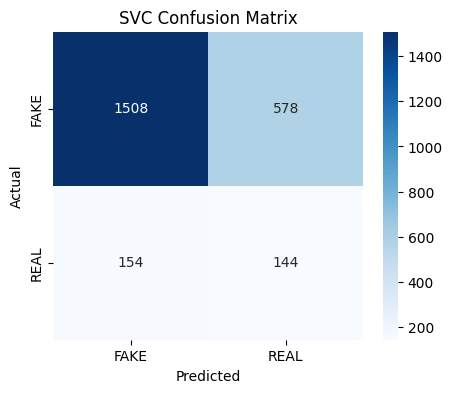


Naive Bayes Metrics:
              precision    recall  f1-score   support

        FAKE       0.94      0.70      0.80      2086
        REAL       0.25      0.68      0.36       298

    accuracy                           0.70      2384
   macro avg       0.59      0.69      0.58      2384
weighted avg       0.85      0.70      0.75      2384



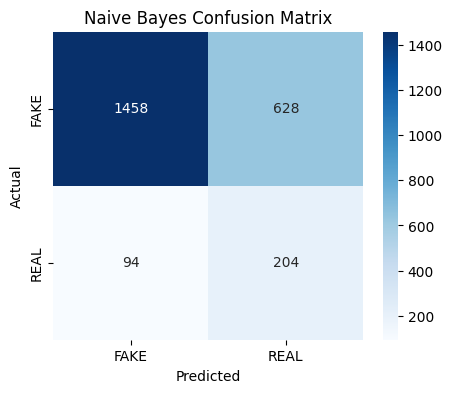


KNN Metrics:
              precision    recall  f1-score   support

        FAKE       0.91      0.72      0.80      2086
        REAL       0.21      0.51      0.29       298

    accuracy                           0.69      2384
   macro avg       0.56      0.62      0.55      2384
weighted avg       0.82      0.69      0.74      2384



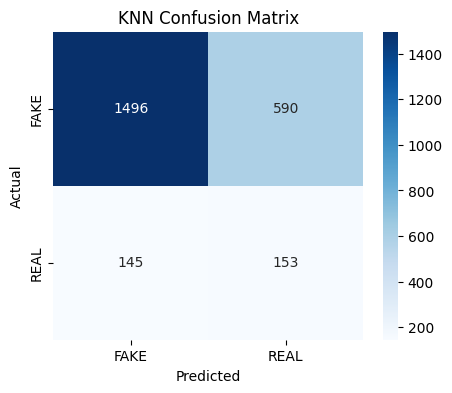


Random Forest Metrics:
              precision    recall  f1-score   support

        FAKE       0.97      0.97      0.97      2086
        REAL       0.78      0.77      0.78       298

    accuracy                           0.94      2384
   macro avg       0.88      0.87      0.87      2384
weighted avg       0.94      0.94      0.94      2384



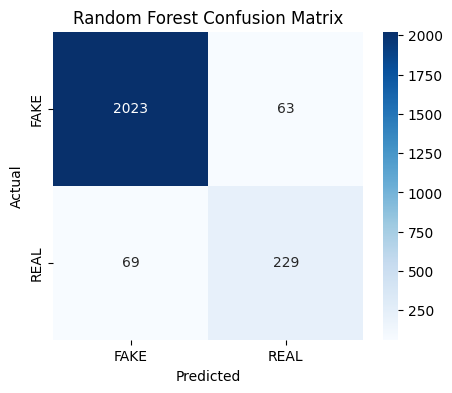


XGBoost Metrics:
              precision    recall  f1-score   support

        FAKE       0.98      0.96      0.97      2086
        REAL       0.77      0.83      0.80       298

    accuracy                           0.95      2384
   macro avg       0.87      0.90      0.88      2384
weighted avg       0.95      0.95      0.95      2384



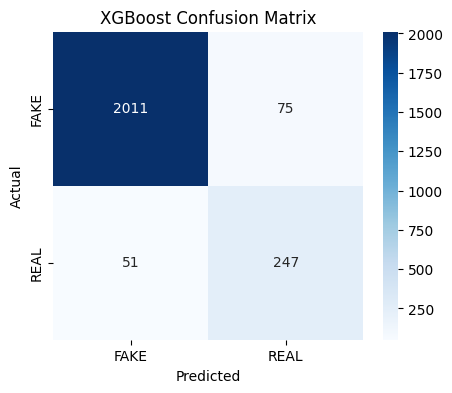


=== Precision-Recall and ROC Curves ===


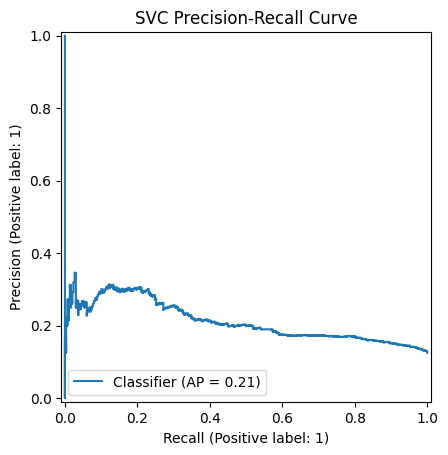

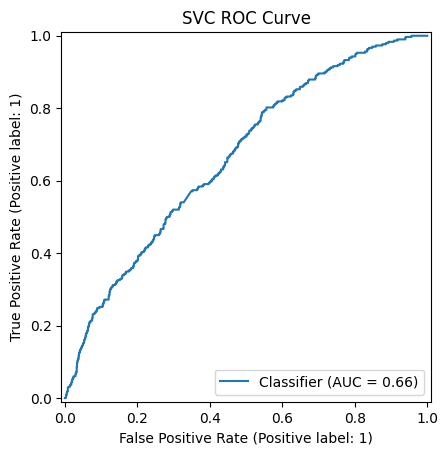

SVC AUC-ROC: 0.6647


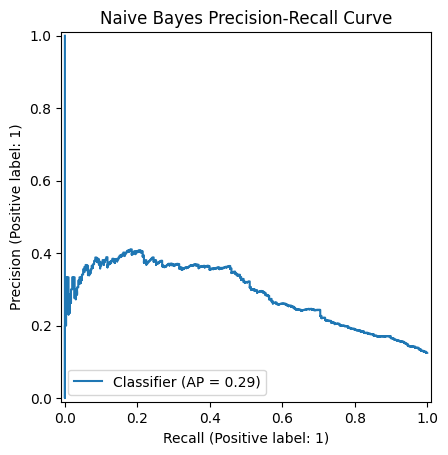

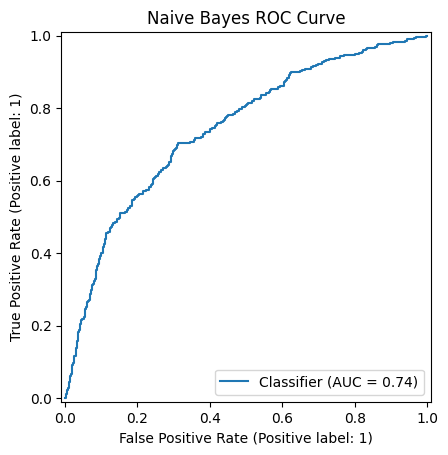

Naive Bayes AUC-ROC: 0.7424


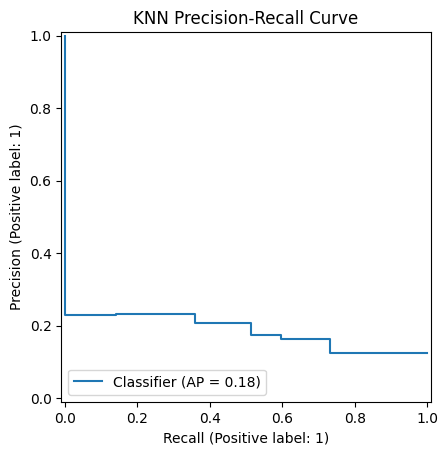

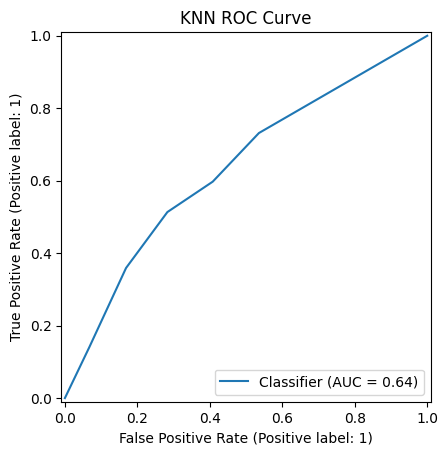

KNN AUC-ROC: 0.6362


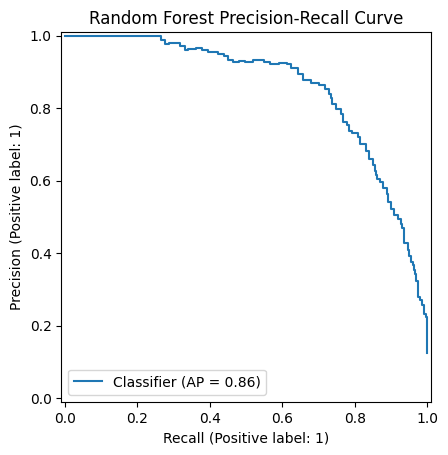

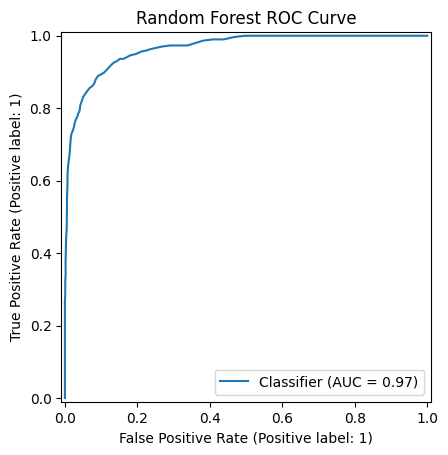

Random Forest AUC-ROC: 0.9652


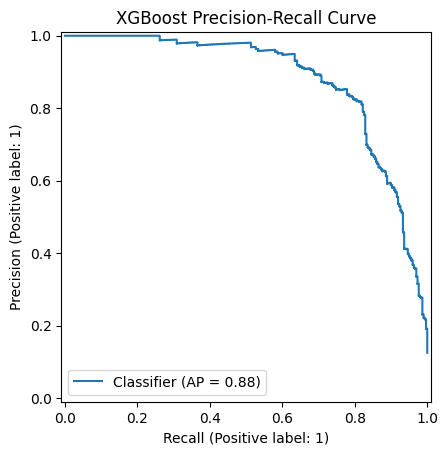

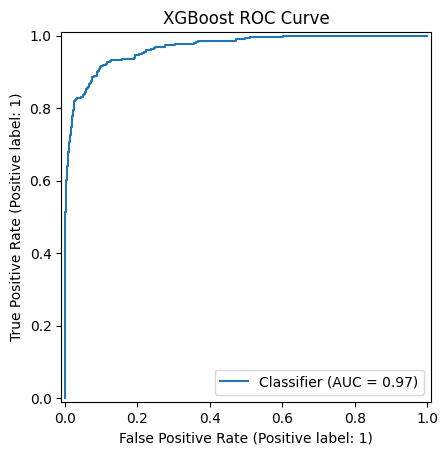

XGBoost AUC-ROC: 0.9674

=== Cross-Validation Scores ===
SVC Cross-Validation Accuracy: Mean = 0.6124, Std = 0.0060
Naive Bayes Cross-Validation Accuracy: Mean = 0.7314, Std = 0.0074
KNN Cross-Validation Accuracy: Mean = 0.8267, Std = 0.0037
Random Forest Cross-Validation Accuracy: Mean = 0.9655, Std = 0.0019
XGBoost Cross-Validation Accuracy: Mean = 0.9694, Std = 0.0016

=== Feature Importance ===

SVC Feature Importance:
               Feature  Importance
22  spectral_bandwidth    0.063842
23    spectral_rolloff    0.042282
0               mfcc_0    0.021225
2               mfcc_2    0.000755
1               mfcc_1    0.000419


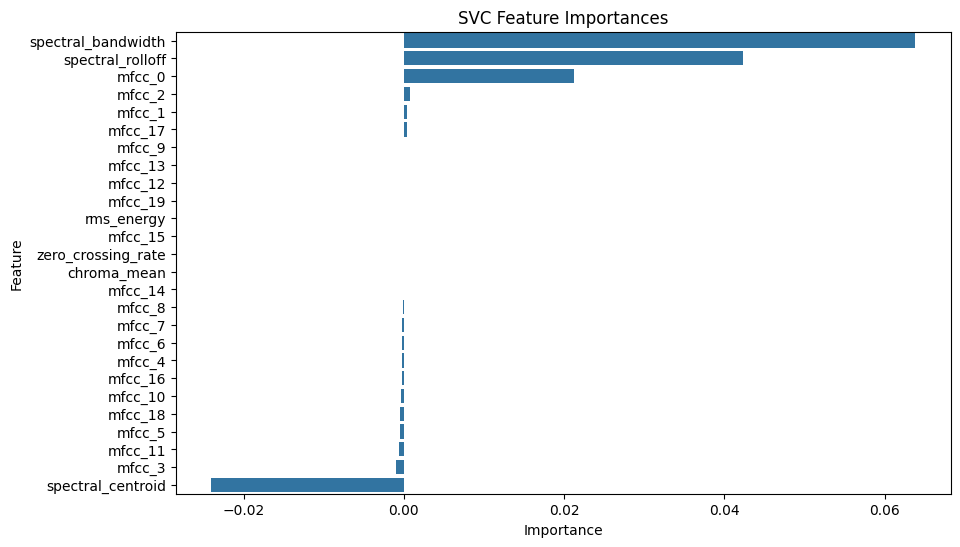


Naive Bayes Feature Importance:
               Feature  Importance
22  spectral_bandwidth    0.014010
7               mfcc_7    0.010906
3               mfcc_3    0.010403
17             mfcc_17    0.010067
5               mfcc_5    0.009983


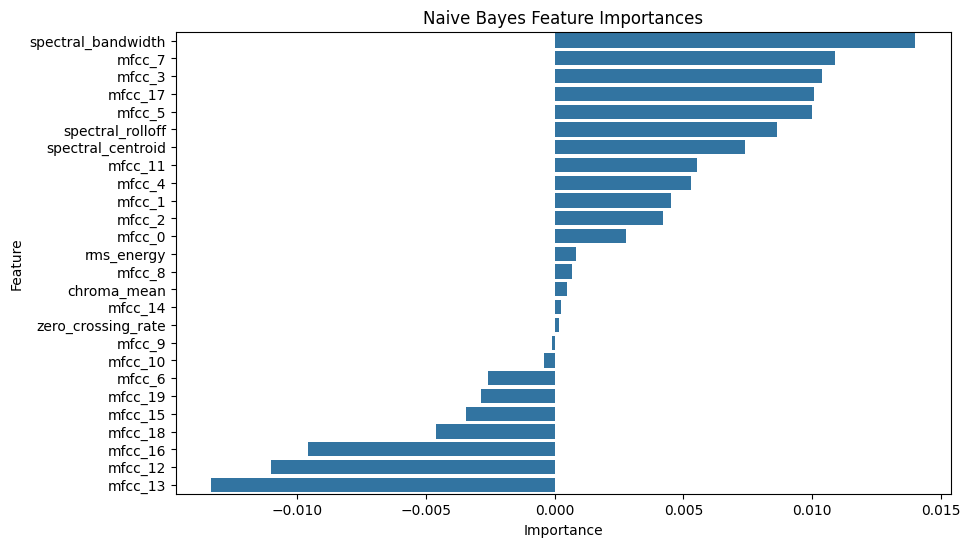


KNN Feature Importance:
               Feature  Importance
22  spectral_bandwidth    0.039262
0               mfcc_0    0.038591
2               mfcc_2    0.006124
3               mfcc_3    0.004782
4               mfcc_4    0.003943


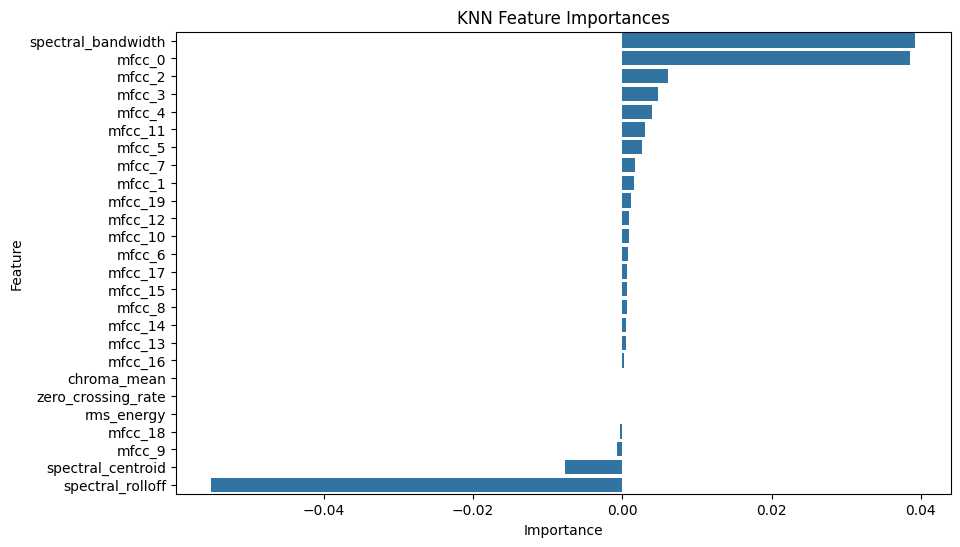


Random Forest Feature Importance:
       Feature  Importance
19     mfcc_19    0.073414
25  rms_energy    0.072666
1       mfcc_1    0.063695
0       mfcc_0    0.062936
17     mfcc_17    0.049502


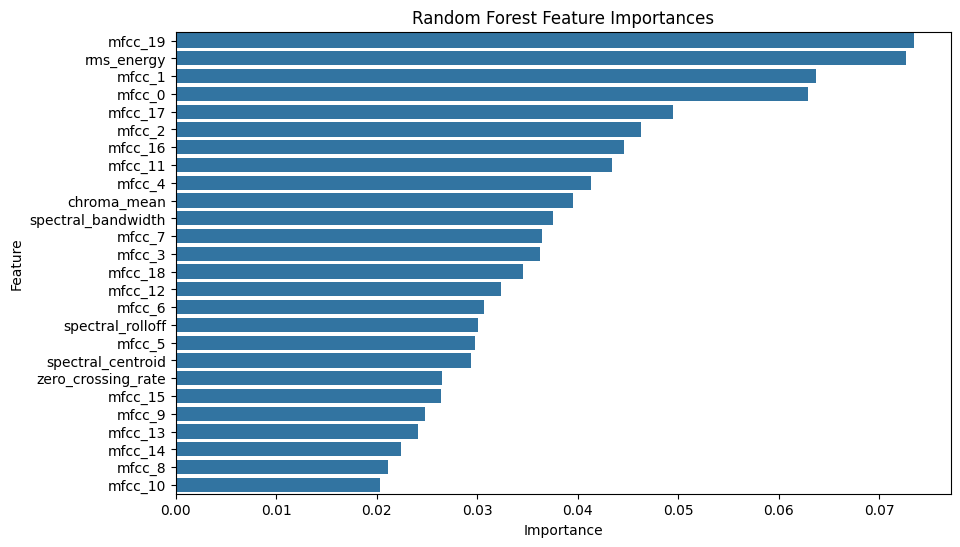


XGBoost Feature Importance:
       Feature  Importance
25  rms_energy    0.095370
19     mfcc_19    0.081134
16     mfcc_16    0.054120
11     mfcc_11    0.053441
2       mfcc_2    0.052517


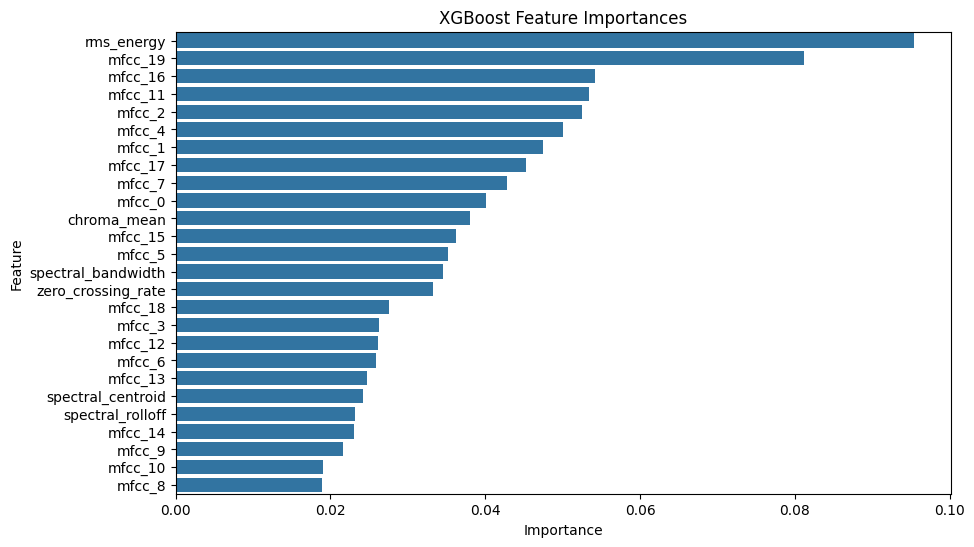


Saving the best model: XGBoost with AUC-ROC: 0.9674


In [18]:
train_and_evaluate_OverSample("/content/drive/MyDrive/KAGGLE/AUDIO/FAKE_REDUCED/FAKE_REDUCED_audio_features_3Secs.csv",
                   "/content/drive/MyDrive/KAGGLE/AUDIO/REAL_REDUCED/REAL_REDUCED_audio_features_3Secs.csv", "")


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


298/298 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7651 - loss: 0.5342 - val_accuracy: 0.8750 - val_loss: 0.3819
Epoch 2/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8690 - loss: 0.4202 - val_accuracy: 0.8750 - val_loss: 0.3836
Epoch 3/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8769 - loss: 0.3968 - val_accuracy: 0.8750 - val_loss: 0.3848
Epoch 4/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8807 - loss: 0.3868 - val_accuracy: 0.8750 - val_loss: 0.3817
Epoch 5/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8687 - loss: 0.4027 - val_accuracy: 0.8750 - val_loss: 0.3813
Epoch 6/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8765 - loss: 0.3843 - val_accuracy: 0.8750 - val_loss: 0.3814
Epoch 7/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8718 - loss: 0.3911 - val_accuracy: 0.8750 - val_loss: 0.3790
Epoch 8/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8748 - loss: 0.3837 - val_accuracy: 0.8750 - val_

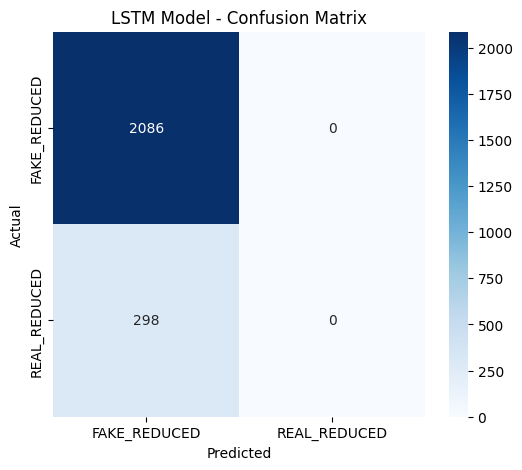

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load the datasets
fake_data = pd.read_csv('/content/drive/MyDrive/KAGGLE/AUDIO/FAKE_REDUCED/FAKE_REDUCED_audio_features_3Secs.csv')
real_data = pd.read_csv('/content/drive/MyDrive/KAGGLE/AUDIO/REAL_REDUCED/REAL_REDUCED_audio_features_3Secs.csv')

# Combine the datasets
data = pd.concat([fake_data, real_data], ignore_index=True)

# Preprocessing
# Separate features and target
X = data.drop(columns=['type', 'file_name', 'interval_start', 'interval_end'])
y = data['type']

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # 'FAKE' -> 0, 'REAL' -> 1

# Reshape for LSTM input (samples, timesteps, features)
X_lstm = np.expand_dims(X.values, axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, random_state=42, stratify=y)

# Convert labels to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_cat, epochs=20, batch_size=32, validation_data=(X_test, y_test_cat))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("LSTM Model - Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


522/522 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5041 - loss: 0.7135 - val_accuracy: 0.8666 - val_loss: 0.6849
Epoch 2/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5040 - loss: 0.6942 - val_accuracy: 0.1904 - val_loss: 0.6936
Epoch 3/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5020 - loss: 0.6940 - val_accuracy: 0.1305 - val_loss: 0.6999
Epoch 4/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5093 - loss: 0.6929 - val_accuracy: 0.1376 - val_loss: 0.6965
Epoch 5/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4940 - loss: 0.6940 - val_accuracy: 0.8750 - val_loss: 0.6907
Epoch 6/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5073 - loss: 0.6926 - val_accuracy: 0.1414 - val_loss: 0.6952
Epoch 7/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4986 - loss: 0.6938 - val_accuracy: 0.1279 - val_loss: 0.7035
Epoch 8/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4999 - loss: 0.6933 - val_accuracy: 0.1279 - val_

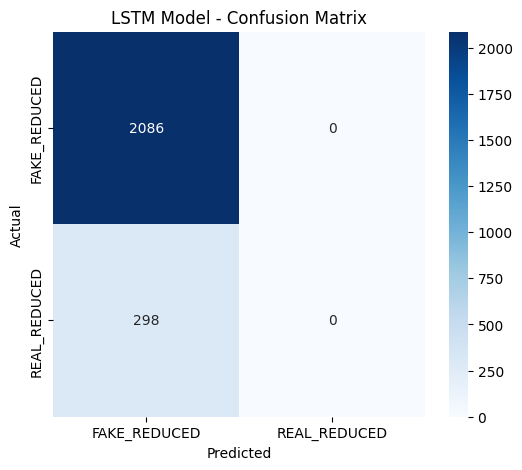

In [20]:
# Oversample real class

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load the datasets
fake_data = pd.read_csv('/content/drive/MyDrive/KAGGLE/AUDIO/FAKE_REDUCED/FAKE_REDUCED_audio_features_3Secs.csv')
real_data = pd.read_csv('/content/drive/MyDrive/KAGGLE/AUDIO/REAL_REDUCED/REAL_REDUCED_audio_features_3Secs.csv')

# Combine the datasets
data = pd.concat([fake_data, real_data], ignore_index=True)

# Preprocessing
# Separate features and target
X = data.drop(columns=['type', 'file_name', 'interval_start', 'interval_end'])
y = data['type']

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # 'FAKE' -> 0, 'REAL' -> 1

# Reshape for LSTM input (samples, timesteps, features)
X_lstm = np.expand_dims(X.values, axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE for oversampling the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

# Reshape the resampled data back for LSTM input
X_train_resampled = np.expand_dims(X_train_resampled, axis=1)

# Convert labels to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train_resampled)
y_test_cat = to_categorical(y_test)

# Define the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_resampled, y_train_cat, epochs=20, batch_size=32, validation_data=(X_test, y_test_cat))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("LSTM Model - Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
